# Exercise 1 - Smoothing and Interpolation

## Introduction

During this exercise we have focused on smoothing and interpolating in both 1D and 2D space.

This is important preprocessing steps as it can reduce noise in medical images and ensure proper registration in later steps.

When applying smoothing we take advantage of nonlinear functions. This increases the flexibility of the model and the model can be desribed as:

$y\mathbf{(x,w)} = w_0 + \sum_{m=1}^{M-1} w_m \, \phi_m(\mathbf{x}),$

where $\phi_m(\mathbf{x})$ describes the basis functions, $w$ are tunable weights that must be estimated using the measurements that are available, and $M$ is a tunable parameter.

During this exercise to find the basis functions we used B-splines which are symmetric functions formed by repeatedly convolving a rectangular pulse $\beta_0$

In this exercise we use the $0^{th}$, $1^{st}$, and $3^{rd}$ order of B-splines by using the following formulas:

$
\beta^{0}(x) =
\begin{cases}
1, & -\dfrac{1}{2} < x < \dfrac{1}{2}, \\[6pt]
\dfrac{1}{2}, & |x| = \dfrac{1}{2}, \\[6pt]
0, & \text{otherwise}.
\end{cases}
$

$
\beta^{1}(x) =
\begin{cases}
1 - |x|, & |x| < 1, \\
0, & \text{otherwise},
\end{cases}
$

$
\beta^{3}(x) =
\begin{cases}
\dfrac{2}{3} - |x|^2 + \dfrac{|x|^3}{2}, & |x| < 1, \\[6pt]
\dfrac{(2 - |x|)^3}{6}, & 1 \leq |x| < 2, \\[6pt]
0, & \text{otherwise}.
\end{cases}
$


### Smoothing
When smoothing the image we estimate denoised signals in a vector or matrix. To do this we use a smoothing matrix $S$ that makes linear combinations of the input 1D vector $\hat t  $or 2D or higher matrix $\hat T  $.

$\hat t = S t$,
where $\mathbf{S} = \mathbf{\Phi} \left( \mathbf{\Phi}^\top \mathbf{\Phi} + \lambda \mathbf{\Omega}^\top \mathbf{\Omega} \right)^{-1} \mathbf{\Phi}^\top$ and $t$ is our input vector.

$\hat T = S_1 T S_2^T$, where $
\mathbf{S_1} = \mathbf{\Phi_1} \left( \mathbf{\Phi_1}^\top \mathbf{\Phi_1} \right)^{-1} \mathbf{\Phi_1}^\top$ and $T$ is our input 2D matrix.







---
### Pre task loading


In [36]:
import numpy as np
import nibabel as nib
from matplotlib import pyplot as plt

np.set_printoptions( suppress=True )
plt.style.use('dark_background') # Dark theme
plt.ion()

T1_file = './IXI002-Guys-0828-T1.nii.gz'
T1_nib = nib.load( T1_file )
data = T1_nib.get_fdata()

img = data[:, :, 75]
T = np.flipud( img.T )

row = round( T.shape[0] / 2 )
t = T[row, :] #pixel intensity at row y = 128

N = t.shape[0]
x = np.arange(0, N)

---
## Task 1: B-splines basis functions
Implement a function that evaluates the uniform B-spline of orders 0, 1 and 3 at the locations provided in a vector $\mathbf{x}$.

The function should return a vector $\mathbf{y}$ that is the same length as $\mathbf{x}$:

    def eval_BSpline(x, order=0):

        """
        Evaluates the uniform B-spline of order "order" at the locations in vector "x"
        """

        ...

        return y


Use this function to plot the uniform B-spline of orders 0, 1 and 3 at locations:  $\mathbf{x} = [-3.0,-2.99,-2.98, \ldots, 2.99,3.0]$

> ***Hint:*** use the function ```np.arange()``` to obtain $\mathbf{x}$.

In [37]:
def eval_BSpline(x, order=0):
    """
    Evaluates the uniform B-spline of order "order" at the locations in vector "x"
    """
    import numpy as np
    if order == 0: # Zero order B-Spline
        out = np.zeros(x.shape)
        out[(x >= -0.5) & (x < 0.5)] = 1
        out[np.abs(x) == 0.5] = 0.5
        out[(x < -0.5) | (x >= 0.5)] = 0

    elif order == 1: # First order B-Spline
        out = np.zeros(x.shape)
        mask = np.abs(x) < 1
        out[mask] = 1 - np.abs(x[mask])

    elif order == 3: # Third order B-Spline
        out = np.zeros(x.shape)
        mask1 = np.abs(x) < 1
        out[mask1] = 2/3-np.abs(x[mask1])**2 + 0.5*np.abs(x[mask1])**3
        mask2 = (1 <= np.abs(x)) & (np.abs(x) < 2)
        out[mask2] = (1/6)*(2-np.abs(x[mask2]))**3
    return out

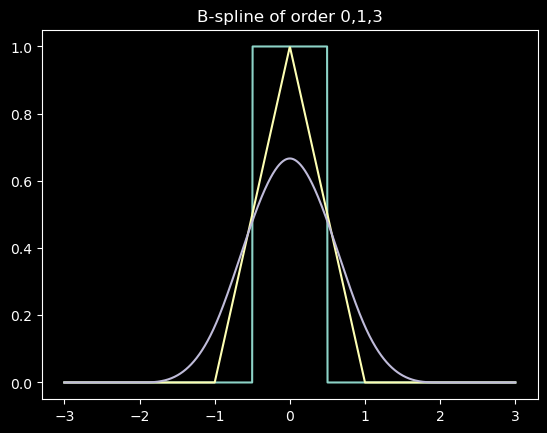

In [38]:
import matplotlib.pyplot as plt
import numpy as np
plotx = np.linspace(-3, 3, 1000)
ploty = eval_BSpline(plotx, order=0) # plot of zero B-Spline in -3,3 space
plt.plot(plotx, ploty)
plt.title('B-spline of order 0,1,3')
ploty = eval_BSpline(plotx, order=1) # plot of first B-Spline in -3,3 space
plt.plot(plotx, ploty)
ploty = eval_BSpline(plotx, order=3) # plot of third B-Spline in -3,3 space
plt.plot(plotx, ploty)



In Task 1, we implemented the function eval_BSpline(x, order) to evaluate uniform B-spline basis functions of order 0, 1, and 3.
- Order 0 corresponds to nearest-neighbor interpolation with a flat box shape.
- Order 1 is linear interpolation, forming a triangular function.
- Order 3 is cubic, providing smooth curves.

By plotting these functions, we can visualize how higher-order B-splines provide smoother and more flexible basis functions, which later influence the smoothing and interpolation tasks.

---
## Task 2: Smoothing
Using the function you wrote above for evaluating a uniform B-spline of order 3, generate $M=6$ basis functions covering the entire domain $x=0,1,\ldots, 255$ of the 1D signal $\mathbf{t}$ defined in the introduction (which has length $N=256$).

The basis functions should be scaled by a factor $h=(N-1)/(M-1)$, and shifted to be $h$ units apart (see book).

Collect the obtained basis functions in a $N \times M$ matrix $\boldsymbol{\Phi}$, and plot them.

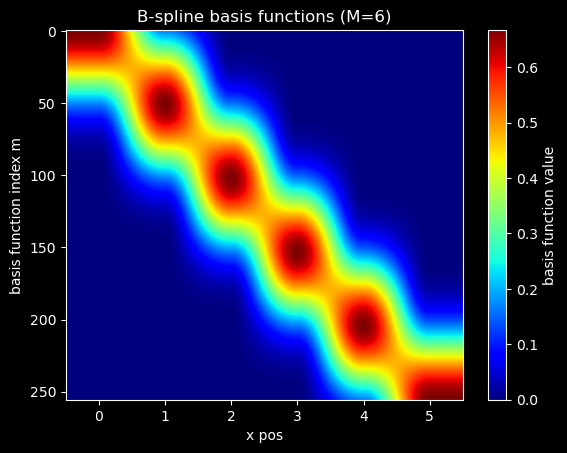

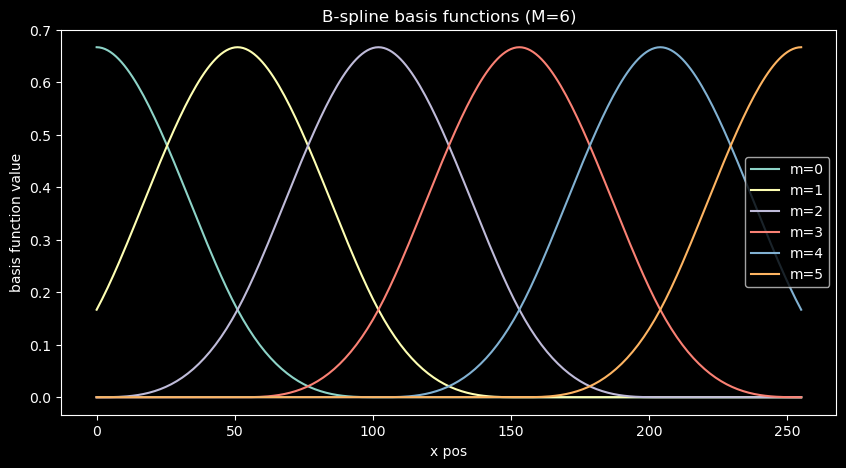

In [39]:
N = len(t)
x = np.linspace(0, N-1, N)
M = 6
phi = np.zeros((N, M))
h = (N-1) / (M-1)
centers = h * np.arange(M)
phi = eval_BSpline((x[:, None]- centers[None, :])/h, order = 3)


plt.imshow(phi, cmap='jet', aspect='auto')
plt.xlabel('x pos')
plt.ylabel('basis function index m')
plt.title('B-spline basis functions (M={})'.format(M))
plt.colorbar(label='basis function value');

# new plot of the basis functions not a heatmap
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5))
for m in range(M):
    ax.plot(x, phi[:, m], label='m={}'.format(m))
ax.set_xlabel('x pos')
ax.set_ylabel('basis function value')
ax.set_title('B-spline basis functions (M={})'.format(M))
ax.legend()


We generated $M=6$ cubic B-spline basis functions $\phi_m(x)$ across the domain $x=0,1,...,255$ of the signal $t$.

The basis functions were shifted by a spacing

$h=\frac{N-1}{M-1}$,   $N=256$,

so that

$\phi_m(x)=B_3(\frac{x-mh}{h})$,

where $B_3$ is the cubic B-spline of order 3.

The heatmap and line plots show that these functions overlap smoothly, and forms the building block for the smoothing.

Compute:
- the smoothing matrix: $\mathbf{S} = \boldsymbol{\Phi} (\boldsymbol{\Phi}^T \boldsymbol{\Phi})^{-1} \boldsymbol{\Phi}^T$
- the smoothed signal:  $\mathbf{\hat{t}} = \mathbf{S} \mathbf{t}$

Plots the results. Also plot the middle row of the smoothing matrix.

>***Hint:***
>
> To compute the solution of a linear equation of the form Ax = b, you can use the following numpy function: ```np.linalg.solve(A, b)```.
>
> You can also use the matrix inversion function ```np.linalg.inv()```, although this is numerically not the best solution.

Text(0.5, 0, 'x pos')

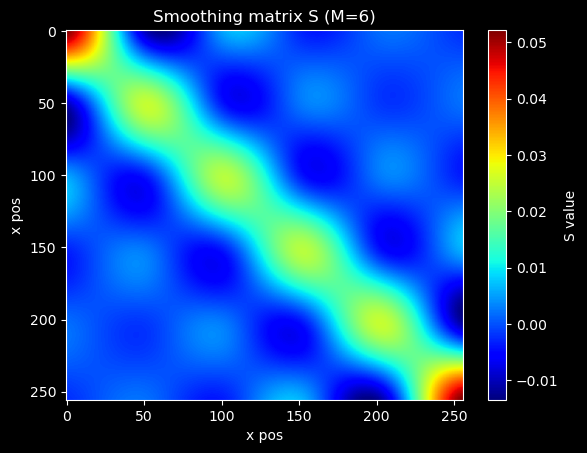

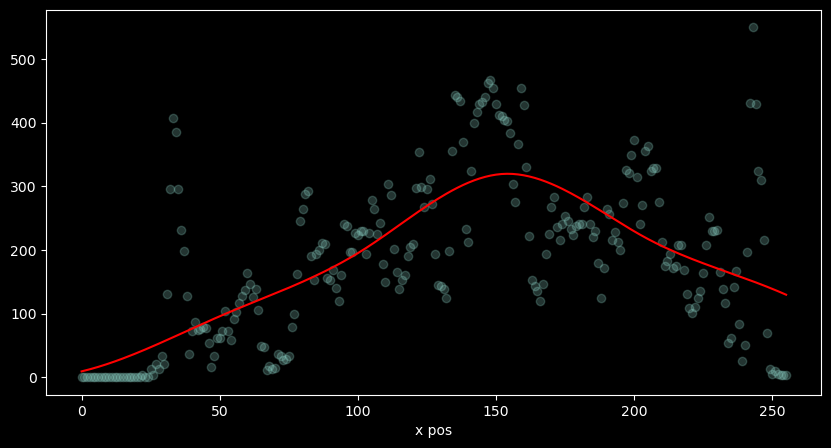

In [40]:
S = phi @ np.linalg.solve(phi.T @ phi, phi.T)
plt.imshow(S, cmap='jet', aspect='auto')
plt.xlabel('x pos')
plt.ylabel('x pos')
plt.title('Smoothing matrix S (M={})'.format(M))
plt.colorbar(label='S value');

t_hat = S @ t
plt.figure(figsize=(10,5))
plt.scatter(x, t, label='data', alpha=0.25)
plt.plot(x, t_hat, 'r', label='smoothed data (M={})'.format(M))
plt.xlabel('x pos')

Now repeat the same experiment when more basis functions are used: $M=16$ and $M=52$.

> ***Q?:*** How does the smoothing behavior change? Explain.

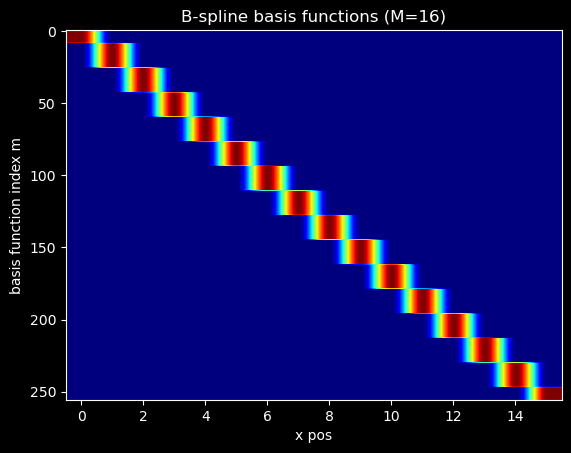

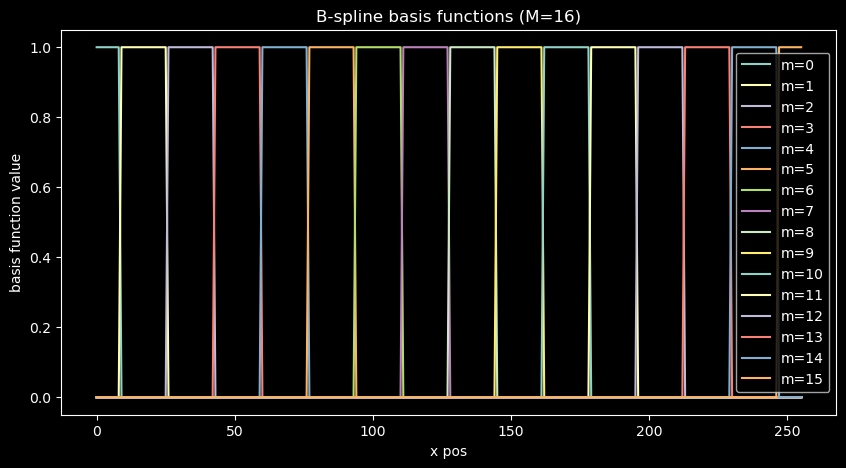

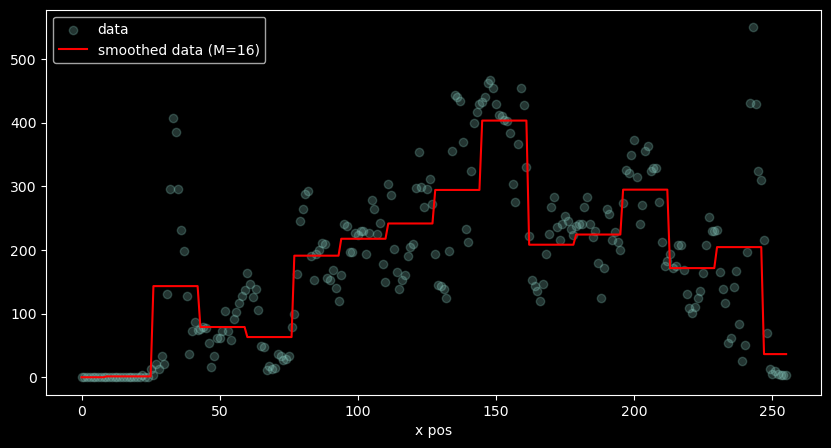

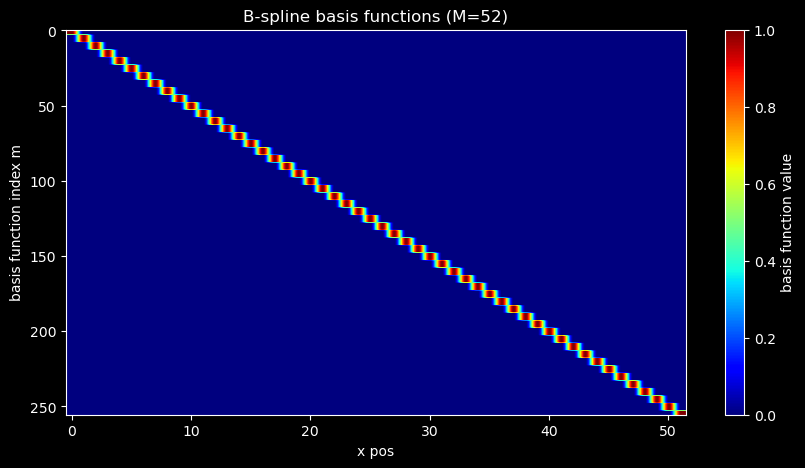

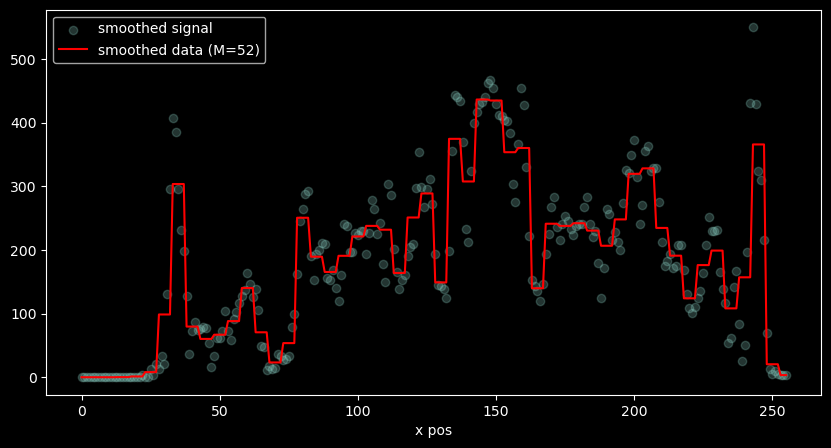

In [41]:
M = 16
h = (N-1) / (M-1)
centers = h*np.arange(M)
phi = eval_BSpline((x[:, None]- centers[None, :])/h, order = 0)

plt.imshow(phi, cmap='jet', aspect='auto')
plt.xlabel('x pos')
plt.ylabel('basis function index m')
plt.title('B-spline basis functions (M={})'.format(M))

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5))
for m in range(M):
    ax.plot(x, phi[:, m], label='m={}'.format(m))
ax.set_xlabel('x pos')
ax.set_ylabel('basis function value')
ax.set_title('B-spline basis functions (M={})'.format(M))
ax.legend()

S = phi @ np.linalg.solve(phi.T @ phi, phi.T)
t_hat = S @ t
plt.figure(figsize=(10,5))
plt.scatter(x, t, label='data', alpha=0.25)
plt.plot(x, t_hat, 'r', label='smoothed data (M={})'.format(M))
plt.xlabel('x pos')
plt.legend()

## 52 basis functions
M = 52
h = (N-1) / (M-1)
centers = h*np.arange(M)
phi = eval_BSpline((x[:, None]- centers[None, :])/h, order = 0)
plt.figure(figsize=(10,5))
plt.imshow(phi, cmap='jet', aspect='auto')
plt.xlabel('x pos')
plt.ylabel('basis function index m')
plt.title('B-spline basis functions (M={})'.format(M))
plt.colorbar(label='basis function value');

S = phi @ np.linalg.solve(phi.T @ phi, phi.T)
t_hat = S @ t
plt.figure(figsize=(10,5))
plt.scatter(x, t, label='smoothed signal', alpha=0.25)
plt.plot(x, t_hat, 'r', label='smoothed data (M={})'.format(M))
plt.xlabel('x pos')
plt.legend()

---
## Task 3: Interpolation
Implement B-spline interpolation of the 1D signal $\mathbf{t}$, by evaluating the function $y( x, \mathbf{w})$ at locations $x = [120, 120.01, 120.02, \ldots 140]$

Show your results, along with the corresponding part of the signal $\mathbf{t}$, for three different orders of B-splines: 0, 1 and 3.

For this part we use 1.3 to calculate weights. $\mathbf{\Phi}$ is calculated the same way as ealier but with N=M.

$\mathbf{w} = (\mathbf{\Phi}^T\mathbf{\Phi})^{-1}\mathbf{\Phi}^T\mathbf{t}$

And the prediction:

$\mathbf{\hat{t}} = \mathbf{\Phi}_1 \mathbf{w}$

Where $\mathbf{\Phi}_1$ is phi, constructed through the interpolated grid/points.

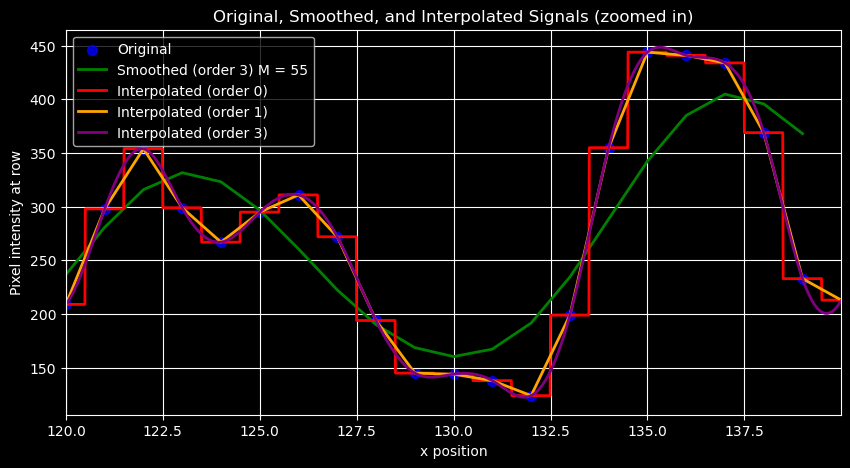

In [42]:
N = len(t)
M = N
h = (N-1) / (M-1)
x = np.linspace(0, N-1, N)
centers = h*np.arange(M)
phi = eval_BSpline((x[:, None]- centers[None, :])/h, order = 0)

def Make_t_Interp(Originalx, t, x_eval, order):
    h = 1
    N = len(t)
    M = N
    centers = h*np.arange(M)
    phi = eval_BSpline((Originalx[:, None] - centers[None, :])/h, order)
    w = np.linalg.solve(phi.T @ phi, phi.T @ t) 
    N_1 = len(x_eval)
    phi_1 = eval_BSpline((x_eval[:, None] - centers[None, :])/h, order)
    t_hat = phi_1 @ w
    return t_hat

def Make_Smooth(t, M, order):
    N = len(t)
    x = np.linspace(0, N-1, N)
    h = (N-1) / (M-1)
    centers = h*np.arange(M)
    phi = eval_BSpline((x[:, None]- centers[None, :])/h, order)
    S = phi @ np.linalg.solve(phi.T @ phi, phi.T)
    t_hat = S @ t
    return t_hat


#Make the smoothed signal, and the interpolated one.

x_Interp = np.arange(120, 140, 0.01)
t_interp = []
t_smooth = []
M_smooth = 55
orders = np.array([0, 1, 3])
for order in orders:
    t_interp.append(Make_t_Interp(x, t, x_Interp, order))
    t_smooth.append(Make_Smooth(t, M_smooth, order))

plt.figure(figsize=(10, 5))
# Original signal (scatter only in interpolation interval)
mask_interp = (x >= x_Interp.min()) & (x <= x_Interp.max())
plt.scatter(x[mask], t[mask], s=50, label="Original", alpha=0.8, color='blue')

# Smoothed signal (only plot inside interval)
plt.plot(x[mask], (t_smooth[2])[mask], color='green', linewidth=2, label=f"Smoothed (order 3) M = {M_smooth}")

orders = [0, 1, 3]
colors = ['red', 'orange', 'purple']
for i, order in enumerate(orders):
    plt.plot(x_Interp, t_interp[i], color=colors[i], linewidth=2, label=f"Interpolated (order {order})")

# Zoom to interpolation interval
plt.xlim(x_Interp.min(), x_Interp.max())

plt.xlabel("x position")
plt.ylabel("Pixel intensity at row")
plt.title("Original, Smoothed, and Interpolated Signals (zoomed in)")
plt.legend()
plt.grid(True)
plt.show()

From this figure, several points are important.

1. Looking at order 0, its clear that we are doing the same as nearest neighbor principle. The point in x_Interp is determined only by what original point is closest.

2. The more order is added, the more points seem important, for the interpolation. Which is also apparant from the intervals in the equations for $\beta^n(x)$

3. The interpolation curves hit all original points, as expected.

---
## Task 4: Smoothing in 2D
Now you are going to smooth the 2D image $\mathbf{T}$, which has dimensions $N_1 \times N_2 = 256 \times 256$, with $M_1=M_2=5$ B-spline-based 1D basis functions of order 3 for each direction.

Use the Kronecker product to produce a $N \times M$ matrix $\boldsymbol{\Phi} = \boldsymbol{\Phi}_2 \otimes \boldsymbol{\Phi}_1$, where:
- $N=N_1 N_2$
- $M = M_1 M_2$.

Show a few 2D basis functions contained in the columns of $\boldsymbol{\Phi}$.

>***Hints***:
>* the Kronecker product of two matrices A and B can be calculated with ```np.kron(A, B)```
>* for converting a vectorized basis function ```v``` back into its 2D shape, use ```v.reshape(N_1, N_2, order='F')```
>* the following snippet can be used to show a 2D basis function:
>    ```
>        plt.figure();
>        ax = plt.axes(projection='3d');
>        ax.plot_wireframe(np.arange(N1).reshape(-1, 1), np.arange(N2).reshape(1, -1), basisFunction)
>
>    ```

In [43]:
def interpolator(x, h, M, order ):
    centers = h * np.arange(M)
    phi1 = eval_BSpline((x[:, None] - centers[None, :])/h, order = order)
    phi2 = eval_BSpline((x[:, None] - centers[None, :])/h, order = order)
    return phi1, phi2

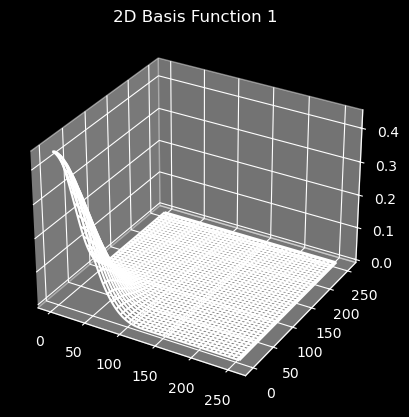

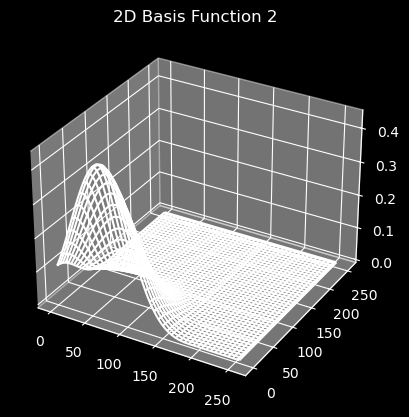

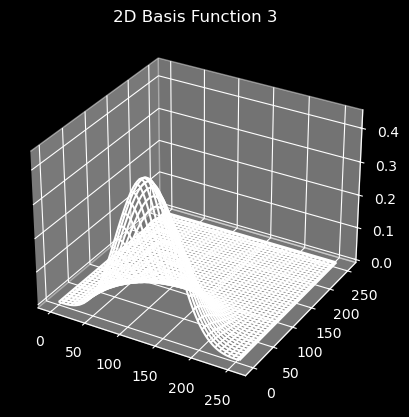

In [44]:
# Use image T
N1, N2 = len(T[1]), len(T[0])
M1, M2 = 5, 5
h1 = (N1-1) / (M1-1)
h2 = (N2-1) / (M2-1)
x1 = np.linspace(0, N1-1, N1)
x2 = np.linspace(0, N2-1, N2)
centers = h*np.arange(M1)
phi1, phi2 = interpolator(x1, h1, M1, 3)

phi = np.kron(phi1, phi2)

def plot_basis_function(basis_function, N1, N2, index):
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_wireframe(
        np.arange(N1).reshape(-1, 1),
        np.arange(N2).reshape(1, -1),
        basis_function
    )
    ax.set_title(f"2D Basis Function {index+1}")
    plt.show()

for i in range(3):
    basis_function = phi[:, i].reshape(N1, N2, order='F')
    plot_basis_function(basis_function, N1, N2, i)

Now:
- vectorize the 2D image $\mathbf{T}$ into a 1D signal $\mathbf{t}$
- smooth using $\boldsymbol{\Phi}$
- re-arrange the resulting 1D signal $\mathbf{\hat{t}}$ back into a 2D image $\mathbf{\hat{T}}$
- show the result.

>***Hints***:
>* use ```T.reshape(-1, 1, order='F')``` and ```t.reshape(N_1, N_2, order='F')``` to vectorize and undo the vectorization.
>* do not explicitly compute the smoothing matrix $\mathbf{S}$ as it is very large!! Instead compute the weights $\mathbf{w} = (\boldsymbol{\Phi}^T \boldsymbol{\Phi})^{-1} \boldsymbol{\Phi}^T \mathbf{t}$ and expand those to get $\mathbf{\hat{t}} = \boldsymbol{\Phi} \mathbf{w}$.


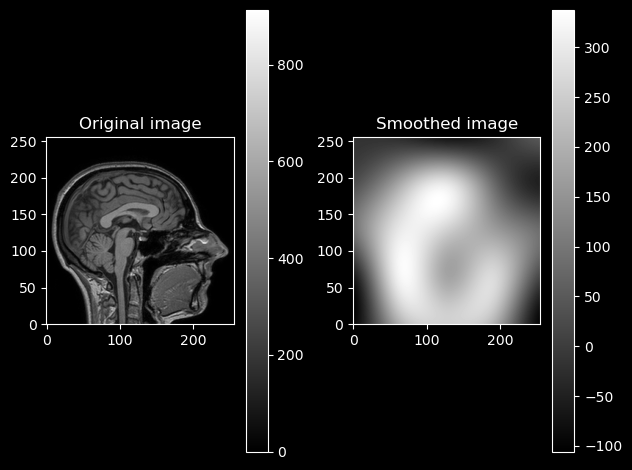

In [45]:
N = 256
M = 5
h = (N-1) / (M-1)
x = np.linspace(0, N-1, N)
phi1, phi2 = interpolator(x, h, M, 3)
phi = np.kron(phi1, phi2)

t = T.reshape(-1, 1, order='F')
w = np.linalg.solve(phi.T @ phi, phi.T @ t)
t_hat = phi @ w # Here we are smoothin by calculated and inverting the whole matrix phi 65536x25, when the basis function increases does the parameters.
T_hat_0 = t_hat.reshape(N1, N2, order='F') # These calculation are costly can in the code we do them more effienctly

plt.figure();
plt.subplot(1,2,1)
plt.imshow(np.rot90(T,2), cmap='gray', origin = 'lower' );# rotate 90 deg
plt.title('Original image')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.rot90(T_hat_0,2), cmap='gray', origin = 'lower');
plt.title('Smoothed image')
plt.colorbar()

plt.tight_layout()
plt.show()


Also perform the same smoothing operation by exploiting the separability of the 2D basis functions, i.e, perform row-wise and then column-wise smoothing instead.

Show the results, and verify that they are identical (use ```np.allclose()```)

True


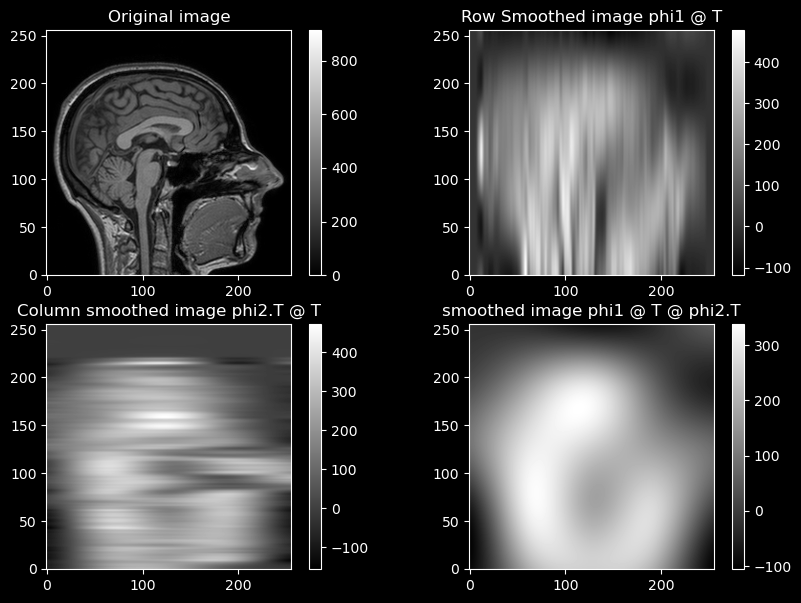

In [46]:
S1 = phi1 @ np.linalg.solve(phi1.T @ phi1, phi1.T) # Here we use the spe
S2 = phi2 @ np.linalg.solve(phi2.T @ phi2, phi2.T)
T_hat_row = S1 @ T
T_hat_col = T @ S2.T
T_hat = S1 @T@ S2.T

print(np.allclose(T_hat, T_hat_0))
plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
plt.imshow(np.rot90(T,2), cmap='gray', origin = 'lower' );
plt.title('Original image')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(np.rot90(T_hat_row,2), cmap='gray', origin = 'lower');
plt.title('Row Smoothed image phi1 @ T')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(np.rot90(T_hat_col,2), cmap='gray', origin = 'lower');
plt.title('Column smoothed image phi2.T @ T')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(np.rot90(T_hat,2), cmap='gray', origin = 'lower');
plt.title('smoothed image phi1 @ T @ phi2.T')
plt.colorbar()
plt.savefig("smoothed_images.png", dpi=300, bbox_inches='tight')


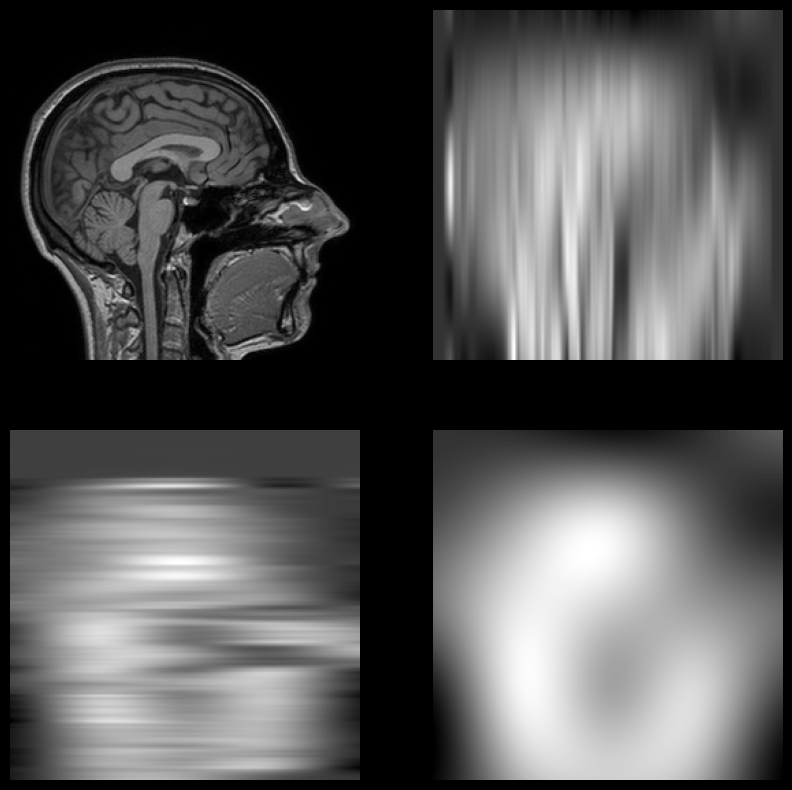

In [47]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(np.rot90(T,2), cmap='gray', origin = 'lower' )
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.rot90(T_hat_row,2), cmap='gray', origin = 'lower')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(np.rot90(T_hat_col,2), cmap='gray', origin = 'lower')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(np.rot90(T_hat,2), cmap='gray', origin = 'lower')
plt.axis('off')

plt.savefig("smoothed_images.png", dpi=300, bbox_inches='tight')

---
## Task 5: Interpolation in 2D
For B-spline order 0, 1 and 3, compute the weights $\mathbf{W}$ of the 2D interpolation model fitted to $\mathbf{T}$ by exploiting the separability of its basis functions.

Then show, as an image, interpolated function values $y( \mathbf{x}, \mathbf{w})$ for $\mathbf{x}=(x_1, x_2)^T$ with:
- $x_1=120.0, 120.1, 120.2 \ldots, 130.0$
- $x_2=120.0, 120.1, 120.2 \ldots, 130.0$

In [48]:
N = 256
M = N
h = (N-1) / (M-1)
x = np.linspace(0, N-1, N)
x1 = np.arange(120, 130, 0.1)
N_1 = len(x1)
# Order 0
phi1, phi2 = interpolator(x, h, M, 0)
phi1_inv = np.linalg.pinv(phi1.T @ phi1)
phi2_inv = np.linalg.pinv(phi2.T @ phi2)
W0 = phi1_inv @ phi1.T @ T @ phi2 @ phi2_inv

phi1, phi2 = interpolator(x1, h, M, 0)
Y0 = phi1 @ W0 @ phi2.T # separability

# Order 1
phi1, phi2 = interpolator(x, h, M, 1)
phi1_inv = np.linalg.pinv(phi1.T @ phi1)
phi2_inv = np.linalg.pinv(phi2.T @ phi2)
W1 = phi1_inv @ phi1.T @ T @ phi2 @ phi2_inv

phi1, phi2 = interpolator(x1, h, M, 1)
Y1 = phi1 @ W1 @ phi2.T

# Order 3
phi1, phi2 = interpolator(x, h, M, 3)
phi1_inv = np.linalg.pinv(phi1.T @ phi1)
phi2_inv = np.linalg.pinv(phi2.T @ phi2)
W3 = phi1_inv @ phi1.T @ T @ phi2 @ phi2_inv

phi1, phi2 = interpolator(x1, h, M, 3)
Y3 = phi1 @ W3 @ phi2.T


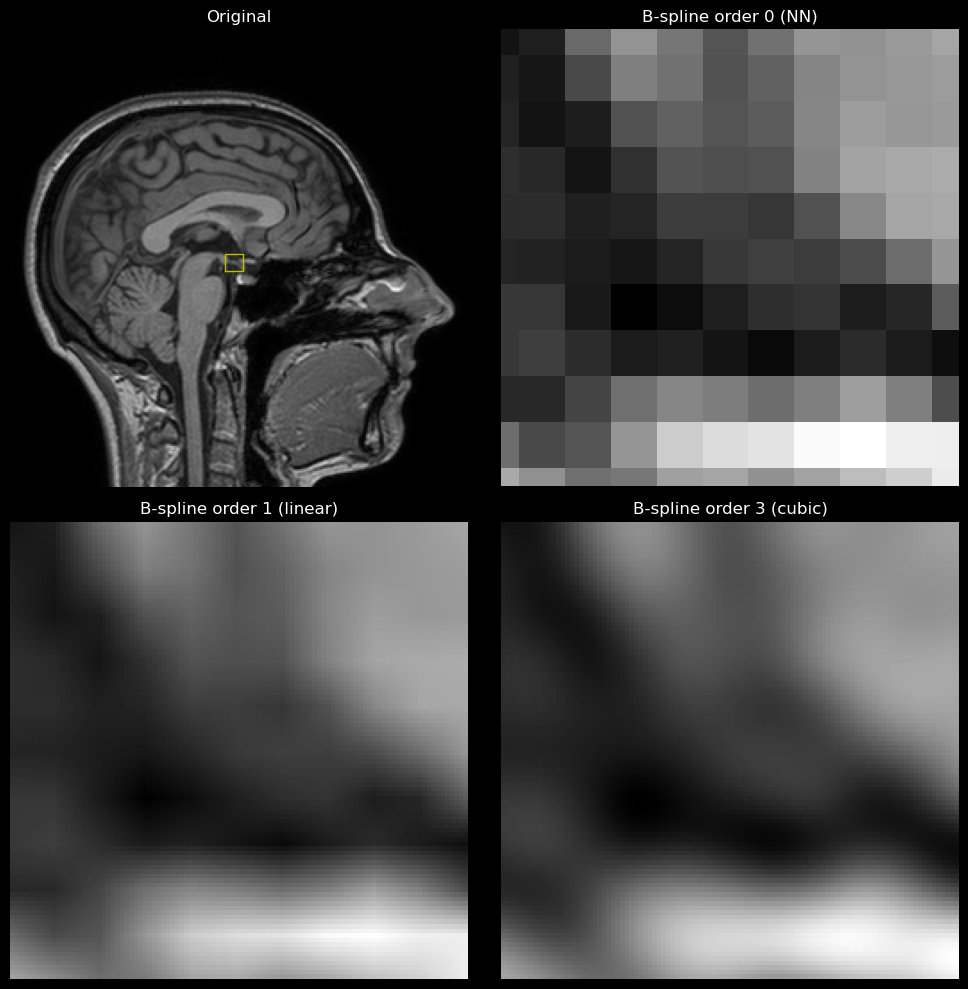

In [49]:

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.ravel()  # flatten to 1D for easy indexing

# Extract Roi
extent_T  = (0, N-1, 0, N-1)
extent_ROI = (x1[0], x1[-1], x1[0], x1[-1])
x0, x1b = x1[0], x1[-1]
y0, y1b = x1[0], x1[-1]

axs[0].imshow(np.rot90(T,2), cmap='gray', origin='lower', extent=extent_T)
axs[0].set_title('Original')
axs[0].axis('off')
axs[0].plot([x0, x1b, x1b, x0, x0],
            [y0, y0,  y1b, y1b, y0],
            lw=1, color='y')


axs[1].imshow(np.rot90(Y0,2), cmap='gray', origin='lower', extent=extent_ROI)
axs[1].set_title('B-spline order 0 (NN)')
axs[1].axis('off')

axs[2].imshow(np.rot90(Y1,2), cmap='gray', origin='lower', extent=extent_ROI)
axs[2].set_title('B-spline order 1 (linear)')
axs[2].axis('off')

axs[3].imshow(np.rot90(Y3,2), cmap='gray', origin='lower', extent=extent_ROI)
axs[3].set_title('B-spline order 3 (cubic)')
axs[3].axis('off')

plt.tight_layout()
plt.show()